In [5]:
import ee
import math
import numpy as np
import pandas as pd

In [2]:
ee.Initialize()

In [3]:
collection = ee.ImageCollection('MODIS/006/MOD13Q1')

In [6]:
# helper function to extract QA bits
def getQABits(image, start, end, newName):
    #Compute the bits we need to extract.
    pattern = 0;
    for i in range(start,end+1):
       pattern += math.pow(2, i);

    # Return a single band image of the extracted QA bits, giving the band
    # a new name.
    return image.select([0], [newName])\
                  .bitwiseAnd(int(pattern))\
                  .rightShift(start);
        
def qualityMask(image):
    quality = getQABits(image.select('SummaryQA'),0,1,'qa')
    mask = quality.eq(0)
    return image.updateMask(mask)

qualityCollection = collection.map(qualityMask)

In [7]:
def smoothSeries(collection,window):
    def smoother(img):
        t = ee.Date(img.get('system:time_start'))
        val = collection.filterDate(t.advance(-window,'day'),t.advance(window,'day')).mean()
        return val.set('system:time_start',t.millis())
    return collection.map(smoother)

smoothCollection = smoothSeries(qualityCollection,15)

In [24]:
# corn field in Iowa
corn = ee.Geometry.Point([-95.314118,43.309286])

out = smoothCollection.select('NDVI').getRegion(corn,250).getInfo()

df = pd.DataFrame(out[1:])
df.columns = out[0]
df.head(5)

,id,longitude,latitude,time,NDVI
0,2000_02_18,-95.31462,43.308903,950832000000,2020.0
1,2000_03_05,-95.31462,43.308903,952214400000,1929.0
2,2000_03_21,-95.31462,43.308903,953596800000,1991.0
3,2000_04_06,-95.31462,43.308903,954979200000,2058.0
4,2000_04_22,-95.31462,43.308903,956361600000,2372.0


In [25]:
date = []
for i in range(df.shape[0]):
    date.append(pd.Timestamp(df.time[i]*1000000))
    
ts = pd.Series(np.array(df.NDVI)*0.0001,index=date,name='lst')
ts.index.name = 'Date'

Populating the interactive namespace from numpy and matplotlib


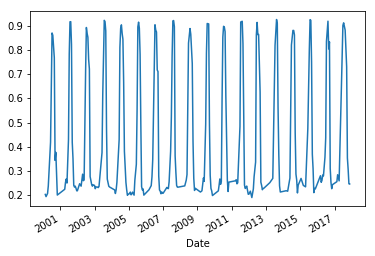

In [26]:
%pylab inline
ts.dropna().plot()

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [38]:
dataset = ts.dropna().values.astype('float32')[:,np.newaxis]

In [39]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [41]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(174, 87)


In [42]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [43]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [44]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.2281
Epoch 2/100
 - 1s - loss: 0.1417
Epoch 3/100
 - 1s - loss: 0.1114
Epoch 4/100
 - 1s - loss: 0.0953
Epoch 5/100
 - 1s - loss: 0.0823
Epoch 6/100
 - 1s - loss: 0.0720
Epoch 7/100
 - 1s - loss: 0.0635
Epoch 8/100
 - 1s - loss: 0.0568
Epoch 9/100
 - 1s - loss: 0.0520
Epoch 10/100
 - 1s - loss: 0.0494
Epoch 11/100
 - 1s - loss: 0.0477
Epoch 12/100
 - 1s - loss: 0.0465
Epoch 13/100
 - 1s - loss: 0.0462
Epoch 14/100
 - 1s - loss: 0.0457
Epoch 15/100
 - 1s - loss: 0.0456
Epoch 16/100
 - 1s - loss: 0.0456
Epoch 17/100
 - 1s - loss: 0.0455
Epoch 18/100
 - 1s - loss: 0.0455
Epoch 19/100
 - 1s - loss: 0.0455
Epoch 20/100
 - 1s - loss: 0.0455
Epoch 21/100
 - 1s - loss: 0.0454
Epoch 22/100
 - 1s - loss: 0.0452
Epoch 23/100
 - 1s - loss: 0.0455
Epoch 24/100
 - 1s - loss: 0.0454
Epoch 25/100
 - 1s - loss: 0.0454
Epoch 26/100
 - 1s - loss: 0.0450
Epoch 27/100
 - 1s - loss: 0.0453
Epoch 28/100
 - 1s - loss: 0.0453
Epoch 29/100
 - 1s - loss: 0.0457
Epoch 30/100
 - 1s - lo

In [46]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.15 RMSE
Test Score: 0.18 RMSE


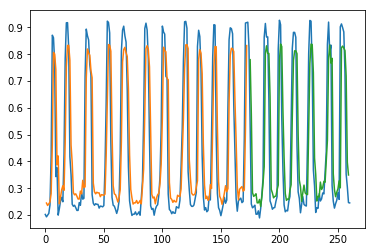

In [47]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()